In [23]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, construct_mbl_circ_with_cut
from gnn import ExpValCircuitGraphModel

In [24]:
backend = FakeMontreal()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [37]:
def generating_func(circ_cut, seed):
    num_spins = 4 # Number of spins. Must be even.
    W = 0.8 * np.pi # Disorder strength up to np.pi
    theta = 0.05 * np.pi # Interaction strength up to np.pi
    steps = 1

    disorders = generate_disorder(num_spins, W, seed=seed)
    qc = construct_mbl_circ_with_cut(num_spins, disorders, theta, steps, broken_connections=circ_cut)
    qc_trans = transpile(qc, backend=backend_noisy, optimization_level=3)
    return qc_trans, qc

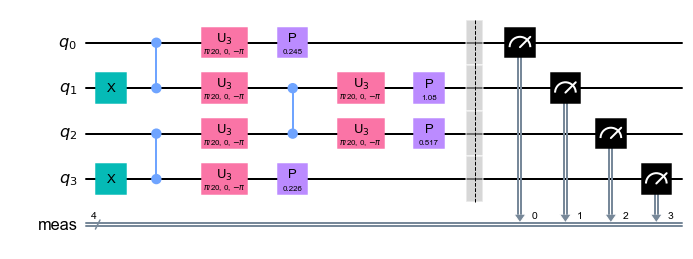

In [38]:
generating_func([], 0)[1].draw('mpl', fold=50, idle_wires=False)

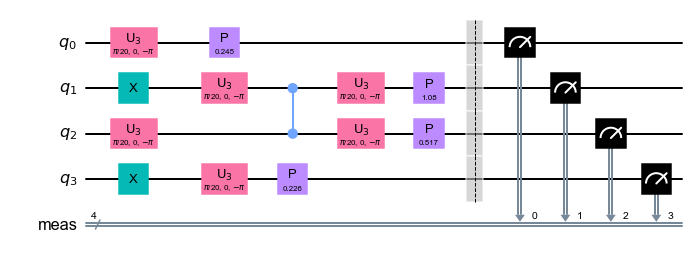

In [41]:
generating_func([(0, 1), (2, 3)], 0)[1].draw('mpl', fold=50, idle_wires=False)

# Circuit Cut Data Generation

In [32]:
from qiskit.transpiler.exceptions import TranspilerError
from scipy.linalg import LinAlgError

def generate_data(circ_cut, save_path: str, n_entries_per_file: int, seed):
    entries = []

    for i in tqdm_notebook(range(n_entries_per_file)):
        success = False
        while not success:
            try:
                circuit = generating_func(circ_cut, seed=seed)[0]
                success = True
            except (LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                print(f"Ran into an error:, {e}")

        job_ideal = execute(circuit, **run_config_ideal)
        job_noisy = execute(circuit, **run_config_noisy)

        counts_ideal = job_ideal.result().get_counts()
        counts_noisy = job_noisy.result().get_counts()

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[noisy_exp_val.tolist()],
            circuit_depth=circuit.depth()
        )
        entries.append(entry.to_dict())

    path = f"{save_path}/step10_cut_23_67_seed{seed}.json"
    with open(path, "w") as f:
        # pprint(entries)
        json.dump(entries, f)

In [33]:
circ_cut = [(2, 3), (6, 7)]
total_num_qubits = 8
seed = 3
# generating_func(circ_cut, seed=seed)[1].draw('mpl', fold=50, idle_wires=False)
generate_data(circ_cut, './data/circ_cut/train', 1000, seed)

  0%|          | 0/1000 [00:00<?, ?it/s]